## The USDA FSA (Farm Service Agency) Livestock Eligibility Program pays out farmers for losses under certain conditions. 

Eligible conditions include temperature below -40C for adult cattle. Using the latest weather data from PRISM, this workflow determines the locations and dates where the temperature satisfies this LIP criteria. 

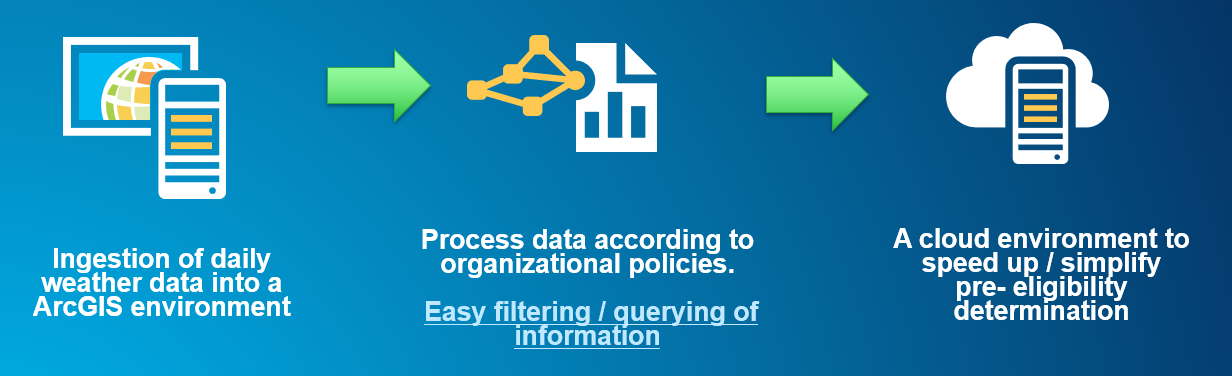

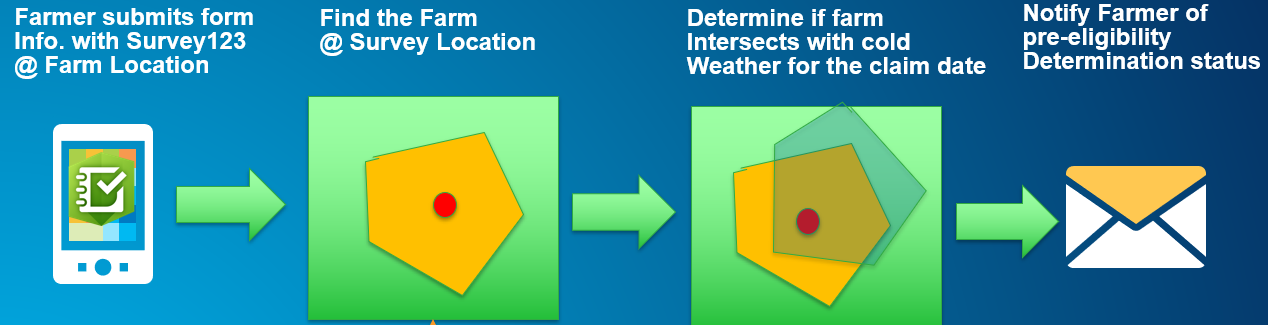

The PRISM group obtains climate observations from a wide range of monitoring networks, applies sophisticated quality control measures, and develops spatial climate datasets to reveal short- and long-term climate patterns. The resulting datasets incorporate a variety of modeling techniques and are available at multiple spatial/temporal resolutions, covering the period from 1895 to the present.

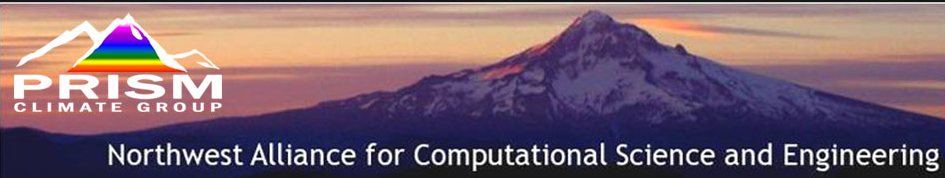

### Minimum daily temperatures are published daily by PRISM as a raster output (.bil extension). Using FTP, this code block downloads the minimum temperature data once every day for analysis. 

In [1]:
#Set paths 
folder_path = "C:\\Users\\lu9739\\Documents\\Projects\\2019\\January\\FSA_Indemity\\DemoTemp"

import datetime, zipfile,os,shutil
import ftplib, logging

logging.basicConfig(filename='prism_ingester_app.log', filemode='w', format='[%(asctime)s] - %(name)s - %(levelname)s - %(message)s')

##PRISM URL 
PRISM_HOME = 'prism.nacse.org'

TARGET_PATH = folder_path
# TARGET_PATH = arcpy.GetParameterAsText(0)
TARGET_FILE = TARGET_PATH  + 'foo.zip'

#Obtain yesterday's date
today = datetime.date.today()
one_day = datetime.timedelta(days=1)
yesterday = today - one_day

#defines file naming convention
DAILY_FILES_PWD = './daily/tmin/' + yesterday.strftime("%Y")
CURR_DATA_FILE_PREFIX = 'PRISM_tmin_early_4kmD1_' + yesterday.strftime("%Y") + yesterday.strftime("%m") + yesterday.strftime("%d") + '_bil'

#Obtains the file and sets it to the naming convention 
try:
    ftp = ftplib.FTP(PRISM_HOME, 'anonymous', 'anonymous@esri.com')
    ftp.cwd(DAILY_FILES_PWD)
except Exception as e:
  logging.error("Exception occurred - Unable to Log in to ftp server", exc_info=True)
  print("Unable to Log in to ftp server")
    
try:
    ftp.retrbinary("RETR "+ CURR_DATA_FILE_PREFIX + '.zip', open(TARGET_FILE, 'wb').write)
    zip_ref = zipfile.ZipFile(TARGET_FILE, 'r')
    zip_ref.extractall(TARGET_PATH)
    zip_ref.close()
    os.remove(TARGET_FILE)        
except Exception as e:
  logging.error("Exception occurred - File Transfer Error", exc_info=True)
  print("File Transfer Error")

ftp.quit()

'221 Goodbye.'

### The downloaded daily minimum temperature dataset will be ingested and processed in a ArcGIS Pro environment. Therefore, we need to define the geodatabase path where the data will reside.  

In [3]:
#define paths of Geodatabase and file
gdb_env = "C:\\Users\\lu9739\\Documents\\ArcGIS\\Projects\\FSA_Indemity\\Automation1.gdb"
#file_path = "C:\\Users\\lu9739\\Documents\FSAtest\\PRISM_tmin_provisional_4kmD1_20190131_bil.bil"
file_path = "C:\\Users\\lu9739\\Documents\\Projects\\2019\\January\\FSA_Indemity\\DemoTemp\\{}.bil".format(CURR_DATA_FILE_PREFIX)
print(file_path)

C:\Users\lu9739\Documents\Projects\2019\January\FSA_Indemity\DemoTemp\PRISM_tmin_early_4kmD1_20190326_bil.bil


### The raster tool ingests the raster dataset within a geodatabase. 

Eligible claim conditions include temperature below -40 C for adult cattle. The Raster Calculator tool is used to reclassify the Minimum Temperature Raster layer into discrete temperature ranges, including a class range that includes temperature below -40 C. 


In [4]:
def set_environment(gdb_env, file_path):
    arcpy.env.workspace = gdb_env
    file_path = file_path
    date = file_path[-16:-8]
    out_raster = arcpy.sa.Raster(file_path)
    filtered_temp = arcpy.sa.Con(out_raster <= -40, -40,arcpy.sa.Con(out_raster <= -30 , -30 ,arcpy.sa.Con(out_raster <= -20, -20 ,arcpy.sa.Con(out_raster <= -10 ,-10 ,arcpy.sa.Con(out_raster <= 0 ,0 , 1)))))
    #filtered_temp  = arcpy.sa.Con(out_raster,1,0, "VALUE < -20" )
    filtered_temp.save(arcpy.env.workspace + "\\RasterFiltered{}".format(date))

    return date

Raster Calculator in a ArcGIS Pro Interface

In [5]:
import arcpy


date = set_environment(gdb_env, file_path)
print(date)

20190326


###  Eligibility personel needs to easily query for eligibility locations and dates. 

By converting the Raster Minimum Temperature Dataset into a Polygon dataset, an attribute table is created for easy querying of the minimum temperature data. Using the cursor module, timestamps are parsed from the file name and added as a new field.

In [6]:
def raster2poly(date):
#Turn the Raster Dataset into a Polygon Dataset
    arcpy.env.workspace = gdb_env
    inraster = "RasterFiltered{}".format(date)
    outpolygon = "Polygon{}".format(date)
    field = "VALUE"
    arcpy.RasterToPolygon_conversion(inraster, outpolygon,"NO_SIMPLIFY", "VALUE")
    

# Select polygons with a value of 1 and copy these values to a new feature class (gridcode variable)    
#    selection = arcpy.SelectLayerByAttribute_management(outpolygon,"NEW SELECTION", '"gridcode" >= 1 ')
#    final_polygon = arcpy.CopyFeatures_management(selection, "FilterPolygon{}".format(date))
    
#Adds timestamps to New Features
    arcpy.AddField_management(outpolygon, "Timestamp",'TEXT', None , None, None, None, "NULLABLE", "NON_REQUIRED", None)
    print("Field Added")
    date = date
    year = date[0:4]
    month = date[4:6]
    day = date[6:]
    cur = arcpy.UpdateCursor(outpolygon)

    for row in cur: 
        row.setValue('Timestamp', "{}{}{}".format(year, month, day))
        cur.updateRow(row)
    print(month, day, year)
    arcpy.ConvertTimeField_management(outpolygon, "Timestamp", "yyyymmdd",'Time', 'DATE')
    return outpolygon

In [6]:
final_features = raster2poly(date)

Field Added
03 24 2019


###  Decison makers accross the country needs access to this dataset. To make the weather repository of daily minimum temperature easily accessible, the features will be moved to an ArcGIS Online cloud environment

Using the capabilities of the ArcGIS API for Python, this script dumps features from the local filegeodatabase containing minimum daily temperature data to an ArcGIS Online feature layer. Since this script will be executed daily, the corresponding AGOL feature layer will be updated to include the latest daily temperature data. 



Older features can be removed (based on date conditionals) everytime this script is updated  

In [7]:
def toAGOL(final_feature): 
#Log into ArcGIS, with password as another parameter
    gis = GIS("https://lnr.maps.arcgis.com/", "l.zhang_LNR")

#Search for the hosted feature layer that will be updated (SevereFacilitiesFC is the empty feature layer)
    search_result1 = gis.content.search(query="title:USDAIndemity_Query", item_type="Feature Layer")
    indemity_item = search_result1[0]
    indemityFC = indemity_item.layers[0]

    # Delete features option 
    #indemityFC.delete_features(deletes=None, where=' Timestamp > 0', geometry_filter=None, gdb_version=None, rollback_on_failure=False)

#Insert new data (features) into AGOL Feature layer from local geodatabase    
    sdf = SpatialDataFrame.from_featureclass(final_feature)
    final_fset = sdf.to_featureset()
    indemityFC.edit_features(adds = final_fset, updates = None, deletes = None, gdb_version = None, rollback_on_failure = False)
    print("Feature Layer Updated")
    print(sdf)

In [8]:
import pandas as pd
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame

toAGOL(final_features)


Enter password: ········
Feature Layer Updated
      OBJECTID    Id  gridcode Timestamp       Time  \
0            1     1       -10  20190324 2019-03-24   
1            2     2         0  20190324 2019-03-24   
2            3     3         1  20190324 2019-03-24   
3            4     4         1  20190324 2019-03-24   
4            5     5         1  20190324 2019-03-24   
5            6     6         1  20190324 2019-03-24   
6            7     7         0  20190324 2019-03-24   
7            8     8         1  20190324 2019-03-24   
8            9     9         1  20190324 2019-03-24   
9           10    10         0  20190324 2019-03-24   
10          11    11         0  20190324 2019-03-24   
11          12    12         1  20190324 2019-03-24   
12          13    13         1  20190324 2019-03-24   
13          14    14         1  20190324 2019-03-24   
14          15    15         1  20190324 2019-03-24   
15          16    16         1  20190324 2019-03-24   
16          17    

### Wipe Geodatabase and folders

In [9]:
import glob

#Clearing folder
#files = glob.glob(--raster folder path--)
#for file in files: 
#    os.remove(file)


#Clearing file geodatabase 
fcs = arcpy.ListFeatureClasses() 
for fc in fcs:
    if arcpy.Exists(fc):
        arcpy.Delete_management(fc)

rasters = arcpy.ListRasters()
for raster in rasters: 
    if arcpy.Exists(raster):
        arcpy.Delete_management(raster)
    

In [ ]:
#from IPython.display import IFrame
#IFrame('http://lnr.maps.arcgis.com/apps/webappviewer/index.html?id=5e073cad18a94821b1beee6e37381852', width=1000, height=600)

### Delete features within FC

In [6]:
'''import pandas as pd
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame



gis = GIS("https://lnr.maps.arcgis.com/", "l.zhang_LNR")

#Search for the hosted feature layer that will be updated (SevereFacilitiesFC is the empty feature layer)
search_result1 = gis.content.search(query="title:USDAIndemity_Query", item_type="Feature Layer")
indemity_item = search_result1[0]
indemityFC = indemity_item.layers[0]

# Delete features option 
indemityFC.delete_features(deletes=None, where=' gridcode = 0', geometry_filter=None, gdb_version=None, rollback_on_failure=False)
'''

Enter password: ········


{'deleteResults': [{'objectId': 34567,
   'uniqueId': 34567,
   'globalId': None,
   'success': True},
  {'objectId': 34568, 'uniqueId': 34568, 'globalId': None, 'success': True},
  {'objectId': 34569, 'uniqueId': 34569, 'globalId': None, 'success': True},
  {'objectId': 34575, 'uniqueId': 34575, 'globalId': None, 'success': True},
  {'objectId': 34578, 'uniqueId': 34578, 'globalId': None, 'success': True},
  {'objectId': 34586, 'uniqueId': 34586, 'globalId': None, 'success': True},
  {'objectId': 34589, 'uniqueId': 34589, 'globalId': None, 'success': True},
  {'objectId': 34593, 'uniqueId': 34593, 'globalId': None, 'success': True},
  {'objectId': 34597, 'uniqueId': 34597, 'globalId': None, 'success': True},
  {'objectId': 34600, 'uniqueId': 34600, 'globalId': None, 'success': True},
  {'objectId': 34601, 'uniqueId': 34601, 'globalId': None, 'success': True},
  {'objectId': 34606, 'uniqueId': 34606, 'globalId': None, 'success': True},
  {'objectId': 34607, 'uniqueId': 34607, 'globalId

### You can now consume the corresponding feature class within a web application. Using the Operations Dashboard, USDA employees can easily identify claims that meets this eligibility criteria. 

<iframe src="https://www.w3schools.com"></iframe>